# Notebook to replicate supplemental control figures for visual behavior paper

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle


# import visual_behavior.data_access.loading as loading # Files should be saved in a clear location
# import visual_behavior.data_access.utilities as utilities
import visual_behavior.visualization.utils as utils

import seaborn as sns
import jetplot
import matplotlib.colors
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 1})

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from visual_behavior.dimensionality_reduction.clustering import plotting # functions to plot clusters
from visual_behavior.dimensionality_reduction.clustering import processing # function for computing and validating clusters

import visual_behavior.visualization.ophys.platform_paper_figures as ppf

In [4]:
import visual_behavior_glm.GLM_fit_dev as gfd
import visual_behavior_glm.GLM_analysis_tools as gat
import visual_behavior_glm.GLM_across_session as gas

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
run_examples=False # skip example runs to run the notebook faster

# Cell ID shuffle control

## Supplemental figure 20

#### Load original data

In [7]:
experience_level_colors = utils.get_experience_level_colors()
cre_line_colors = utils.get_cre_line_colors()

experience_levels = utils.get_new_experience_levels()
cell_types = utils.get_cell_types()

In [8]:
# path to data file
base_path = '//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache_new'
#base_path = os.path.abspath(path)

# create folder to load and save to
folder = 'clustering'
save_dir = os.path.join(base_path, folder)


In [9]:
fig_path = '//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_figures_final'


#### Load original feature matrix, meta data and cluster labels

In [10]:
# coding scores from GLM for matched cells during familiar, novel, and novel+ sessions
filename = 'clustering_feature_matrix.h5'
original_feature_matrix = pd.read_hdf(os.path.join(save_dir, filename), key='df')
len(original_feature_matrix)

3921

In [11]:
# cluster assignments and other info about the cells. Note that 20 cells were dropped post clustering since there were less than 5 of them in a cluster
filename = 'old_files/cluster_meta_14_clusters.h5' 
original_cluster_meta = pd.read_hdf(os.path.join(save_dir, filename), key='df')
len(original_cluster_meta)

3901

In [12]:
# # this should be the way to laod cells table
# filename = 'cell_metadata.h5'
# cells_table = pd.read_hdf(os.path.join(save_dir, filename), key='df')
# matched_cells_table = loading.get_matched_cells_table(cells_table)

In [13]:
# REMOVE!!!
# run this cell if cell above doesnt run
filename = 'old_files/cell_metadata.pkl'
cells_table = pd.read_pickle(os.path.join(save_dir, filename))


In [14]:
# run this cell if cell above doesnt run
filename = 'old_files/matched_cells_table.pkl'
cells_table = pd.read_pickle(os.path.join(save_dir, filename))

### Compute mean cluster coding scores for the original data

In [15]:
# 12x1 matrix
original_mean_dropout_scores = processing.get_mean_dropout_scores_per_cluster(original_feature_matrix, 
                                                  cluster_meta = original_cluster_meta.reset_index(), sort=True)
# dictionary of 4x3 clusters
original_mean_dropout_scores_unstacked = processing.get_mean_dropout_scores_per_cluster(original_feature_matrix, stacked=False, 
                                                  cluster_meta = original_cluster_meta.reset_index(), sort=True)

In [16]:
# split cell specimen ids by cre lines 
cre_ids = {}
cre_lines = np.sort(original_cluster_meta.cre_line.unique())
for cre_line in cre_lines:
    cre_ids[cre_line]=original_cluster_meta[original_cluster_meta.cre_line==cre_line].index.values
    

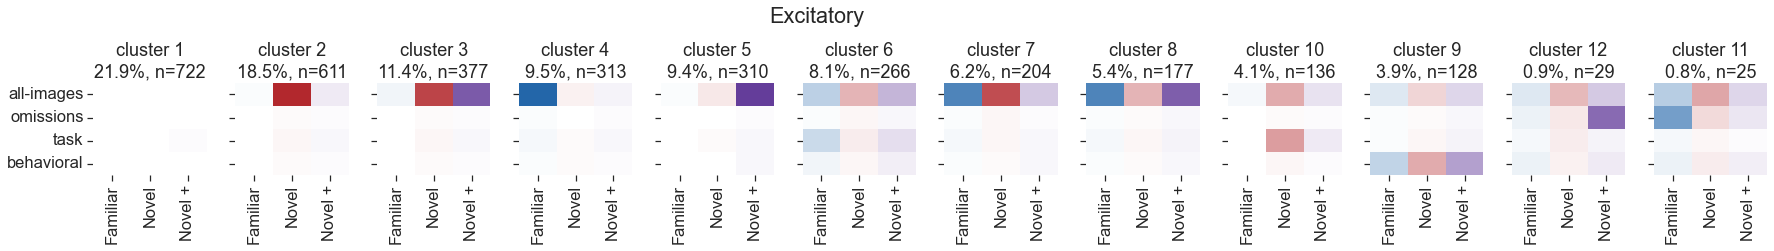

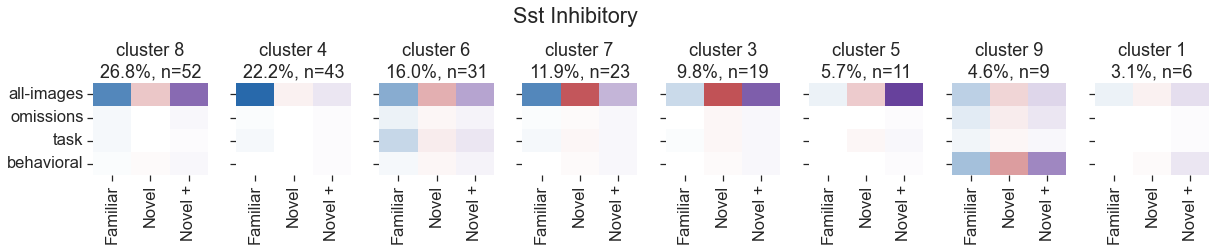

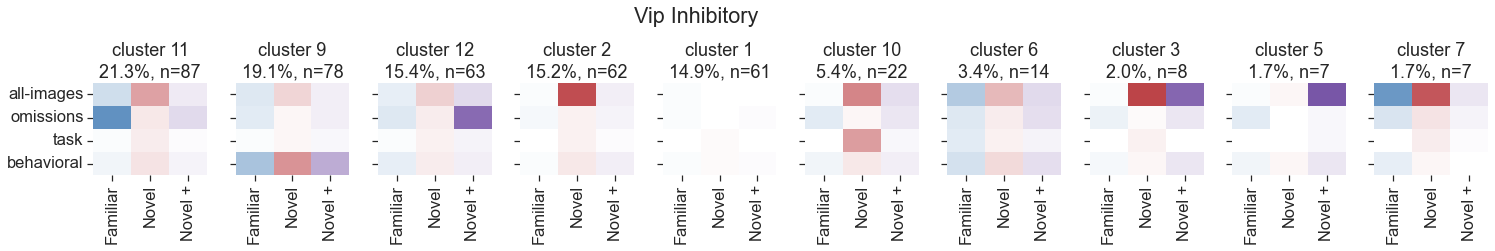

In [74]:
for cre_line in cre_lines:
    cluster_meta_cre = original_cluster_meta[original_cluster_meta.cre_line==cre_line]
    clusters = cluster_meta_cre.value_counts('cluster_id').index.values
    plotting.plot_mean_cluster_heatmaps_remapped(original_feature_matrix, cluster_meta_cre, cre_line, clusters, 
                                                 session_colors=True, save_dir=fig_path, folder=folder)

#### Load shuffled data

In [17]:
# Original data in clusters was shuffled 500 times. 
# load cached shuffled coding scores. 

# shuffle_dir = os.path.join(save_dir, folder, 'shuffled_files')
tmp_path = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\clustering\shuffled_files'
shuffle_dir = tmp_path
n_boots=np.arange(500)
shuffle_type = 'experience'
nb_shuffled = {}
for n_boot in n_boots:
    nb_filename ='all_cells_{}_nb{}.h5'.format(shuffle_type, n_boot)
    feature_matrix = pd.read_hdf(os.path.join(shuffle_dir,nb_filename), key = 'df')
    # clean the names of the experience levels and make sure that regressors are ordered correctly
    nb_shuffled[n_boot] = feature_matrix[processing.get_features_for_clustering()].rename(mapper = {'Novel 1': 'Novel', 'Novel >1': 'Novel +'}, axis=1)
shuffled_feature_matrices = nb_shuffled

In [45]:
# to create new shuffled data:
if run_examples:
    shuffled_matrix_example = processing.shuffle_dropout_score(feature_matrix, shuffle_type='experience', separate_cre_lines=False)

array([<AxesSubplot:title={'center':'Excitatory'}, xlabel='experience_level'>,
       <AxesSubplot:title={'center':'Sst Inhibitory'}, xlabel='experience_level'>,
       <AxesSubplot:title={'center':'Vip Inhibitory'}, xlabel='experience_level'>],
      dtype=object)

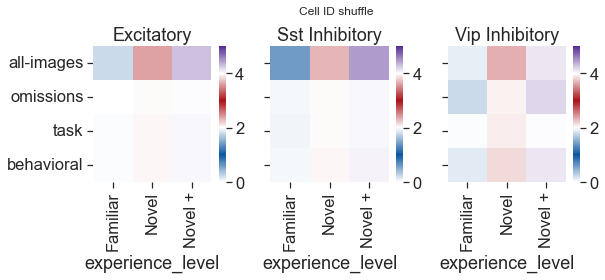

In [46]:
# plot mean dropout scores for shuffled dataset, which should look like the original
plotting.plot_mean_shuffled_feature_matrix(shuffled_feature_matrices, original_cluster_meta, 
                                           session_colors=True, experience_index=None, save_dir=fig_path, folder=folder)


#### Cluster shuffled data

In [ ]:
# example of clustering one shuffled dataset.
# to apply it to multiple shuffled dataset, loop through shuffled_feature_matrices
from sklearn.cluster import SpectralClustering
n_clusters=12 # same as what we have in original data, this can be optimized for each clustering iteration, but would be very time consuming.
for n_boot in n_boots[:2]:
    sc = SpectralClustering()
    X = nb_shuffled[n_boot].values
    m = processing.get_coClust_matrix(X=X, n_clusters=n_clusters, model=sc, nboot=np.arange(150)) #
    # make co-clustering matrix a dataframe with cell_specimen_ids as indices and columns
    coclustering_df = pd.DataFrame(data=m, index=feature_matrix.index, columns=feature_matrix.index)
    shuffled_cluster_meta = processing.create_and_save_cluster_meta(coclustering_df, n_clusters, feature_matrix, cells_table_matched, cluster_meta_filename=None)


In [47]:
if run_examples:
    # example of clustering one shuffled dataset.
    # to apply it to multiple shuffled dataset, loop through shuffled_feature_matrices
    from sklearn.cluster import SpectralClustering
    n_clusters=12 # same as what we have in original data, this can be optimized for each clustering iteration, but would be very time consuming.
    sc = SpectralClustering()
    X = feature_matrix.values
    m = processing.get_coClust_matrix(X=X, n_clusters=n_clusters, model=sc, nboot=np.arange(150)) #
    # make co-clustering matrix a dataframe with cell_specimen_ids as indices and columns
    coclustering_df = pd.DataFrame(data=m, index=feature_matrix.index, columns=feature_matrix.index)
    shuffled_cluster_meta = processing.create_and_save_cluster_meta(coclustering_df, n_clusters, feature_matrix, cells_table_matched, cluster_meta_filename=None)


#### Load cluster labels

In [48]:
%%time
## Load shuffled cluster labels
nb_labels_shuffled = {}                       
for n_boot in n_boots:
    nb_filename ='all_cells_{}_nb{}_cluster_labels.h5'.format(shuffle_type, n_boot) 
    full_filename = os.path.join(shuffle_dir, nb_filename)
    nb_labels_shuffled[n_boot] = pd.read_hdf(full_filename, key = 'clustered_df')
shuffled_labels = nb_labels_shuffled

Wall time: 1min


## Compute mean dropout scores for each cluster, each shuffle type, cre_line, and nboot from shuffled dfs

Mean dropout scores are needed for each cluster in order to match original clusters with shuffled

In [49]:
n_clusters=12

In [50]:
# mean dropout scores for all 12 clusters in each iteration of shuffle for all cell types together
# these averages are what is used to compare shuffled clusters to original clusters when computing SSE

nb_mean_dropout_scores_shuffled = {}
for n, n_boot in enumerate(n_boots):
    cluster_meta = shuffled_labels[n] # cluster ids with cell specimen ids
    feature_matrix = nb_shuffled[n] # shuffled feature matrix
    mean_dropout_scores = processing.get_mean_dropout_scores_per_cluster(feature_matrix, 
                                                      cluster_meta = cluster_meta, stacked=True, max_n_clusters=n_clusters)
    nb_mean_dropout_scores_shuffled[n] = mean_dropout_scores


In [52]:
nb_mean_dropout_scores_shuffled_unstacked = {}
for n, n_boot in enumerate(n_boots):
    cluster_meta = shuffled_labels[n] # cluster ids with cell specimen ids
    feature_matrix = nb_shuffled[n] # shuffled feature matrix
    mean_dropout_scores_unstacked = processing.get_mean_dropout_scores_per_cluster(feature_matrix, 
                                                      cluster_meta = cluster_meta, stacked=False,max_n_clusters=n_clusters)
    nb_mean_dropout_scores_shuffled_unstacked[n] = mean_dropout_scores_unstacked

In [60]:
# mean dropout scores for all 12 clusters in each iteration of shuffle separated by cre lines
# This is helpful for plotting clusters for each cre line
# This matrix is also used for 
cre_mean_dropout_scores_shuffled = {}
for cre_line in cre_lines:
    nb_mean_dropout_scores_shuffled = {}
    for n, n_boot in enumerate(n_boots):
        cluster_meta = shuffled_labels[n] # cluster ids with cell specimen ids
        cluster_meta_cre  = cluster_meta[cluster_meta.cre_line==cre_line]
        feature_matrix_cre = nb_shuffled[n].loc[cre_ids[cre_line]] # shuffled feature matrix
        mean_dropout_scores = processing.get_mean_dropout_scores_per_cluster(feature_matrix_cre, 
                                                      cluster_meta = cluster_meta_cre, max_n_clusters=n_clusters)
        nb_mean_dropout_scores_shuffled[n] = mean_dropout_scores
    cre_mean_dropout_scores_shuffled[cre_line] = nb_mean_dropout_scores_shuffled

In [67]:
cids = cluster_meta_cre[cluster_meta_cre.cluster_id==10].cell_specimen_id.values

In [72]:
feature_matrix_cre.loc[cids].mean()

            experience_level
all-images  Familiar            0.119220
            Novel               0.303041
            Novel +             0.102466
omissions   Familiar            0.121441
            Novel               0.087595
            Novel +             0.084427
task        Familiar            0.019935
            Novel               0.087530
            Novel +             0.031813
behavioral  Familiar            0.060169
            Novel               0.130929
            Novel +             0.685505
dtype: float64

In [61]:
mean_dropout_scores

,1,2,3,4,5,6,7,8,9,10,11,12
0,0.031926,0.158993,0.898056,0.068546,0.044139,0.176218,0.058689,0.685433,NaN,0.119220,0.736797,0.037587
1,0.081378,0.314295,0.742048,0.067262,0.205969,0.333801,0.778032,0.212112,NaN,0.303041,0.070611,0.721929
2,0.046968,0.111274,0.000000,0.773763,0.124661,0.115760,0.730575,0.922400,NaN,0.102466,0.041514,0.034972
3,0.048013,0.150703,0.303365,0.127970,0.087703,0.657694,0.316948,0.341400,NaN,0.121441,0.083491,0.058713
4,0.026279,0.058632,0.026000,0.082981,0.062455,0.052314,0.030921,0.000949,NaN,0.087595,0.019118,0.087660
5,0.073715,0.465743,0.232858,0.124449,0.073160,0.120455,0.081624,0.022609,NaN,0.084427,0.055220,0.069521
6,0.008212,0.022211,0.000000,0.000000,0.030637,0.033884,0.056154,0.000000,NaN,0.019935,0.050348,0.007185
7,0.052932,0.070571,0.017377,0.037322,0.096165,0.065123,0.055491,0.007179,NaN,0.087530,0.093374,0.118506
8,0.017398,0.029375,0.030936,0.048227,0.011855,0.027779,0.005864,0.113159,NaN,0.031813,0.004462,0.012048
9,0.040420,0.340830,0.007070,0.025007,0.051646,0.071699,0.089661,0.203948,NaN,0.060169,0.144179,0.023559


In [58]:
# to plot matched clusters by cre line
cre_mean_dropout_scores_shuffled_unstacked = {}
for cre_line in cre_lines:
    nb_mean_dropout_scores_shuffled_unstacked = {}
    for n, n_boot in enumerate(n_boots):
        cluster_meta = shuffled_labels[n] # cluster ids with cell specimen ids
        cluster_meta_cre  = cluster_meta[cluster_meta.cre_line==cre_line]            
        feature_matrix_cre = nb_shuffled[n].loc[cre_ids[cre_line]] 
        mean_dropout_scores_unstacked = processing.get_mean_dropout_scores_per_cluster(feature_matrix_cre, 
                                                      cluster_meta = cluster_meta_cre,stacked=False,max_n_clusters=n_clusters)
        nb_mean_dropout_scores_shuffled_unstacked[n] = mean_dropout_scores_unstacked
    cre_mean_dropout_scores_shuffled_unstacked[cre_line] = nb_mean_dropout_scores_shuffled_unstacked

In [59]:
 mean_dropout_scores_unstacked 

{1: experience_level  Familiar     Novel   Novel +
 all-images        0.031926  0.081378  0.046968
 behavioral        0.040420  0.040041  0.040377
 omissions         0.048013  0.026279  0.073715
 task              0.008212  0.052932  0.017398,
 2: experience_level  Familiar     Novel   Novel +
 all-images        0.158993  0.314295  0.111274
 behavioral        0.340830  0.149222  0.069581
 omissions         0.150703  0.058632  0.465743
 task              0.022211  0.070571  0.029375,
 3: experience_level  Familiar     Novel   Novel +
 all-images        0.898056  0.742048  0.000000
 behavioral        0.007070  0.138020  0.059259
 omissions         0.303365  0.026000  0.232858
 task              0.000000  0.017377  0.030936,
 4: experience_level  Familiar     Novel   Novel +
 all-images        0.068546  0.067262  0.773763
 behavioral        0.025007  0.060342  0.066568
 omissions         0.127970  0.082981  0.124449
 task              0.000000  0.037322  0.048227,
 5: experience_level  Fa

In [57]:
 mean_dropout_scores_unstacked 

{1: experience_level  Familiar     Novel   Novel +
 all-images        0.031926  0.081378  0.046968
 omissions         0.048013  0.026279  0.073715
 task              0.008212  0.052932  0.017398
 behavioral        0.040420  0.040041  0.040377,
 2: experience_level  Familiar     Novel   Novel +
 all-images        0.158993  0.314295  0.111274
 omissions         0.150703  0.058632  0.465743
 task              0.022211  0.070571  0.029375
 behavioral        0.340830  0.149222  0.069581,
 3: experience_level  Familiar     Novel   Novel +
 all-images        0.898056  0.742048  0.000000
 omissions         0.303365  0.026000  0.232858
 task              0.000000  0.017377  0.030936
 behavioral        0.007070  0.138020  0.059259,
 4: experience_level  Familiar     Novel   Novel +
 all-images        0.068546  0.067262  0.773763
 omissions         0.127970  0.082981  0.124449
 task              0.000000  0.037322  0.048227
 behavioral        0.025007  0.060342  0.066568,
 5: experience_level  Fa

### panel c and d - SSE matching heatmap 


In [41]:
# Compute Sum of Squared Error between original clusters and each iteration of shuffled clusters. 
# Low value indicates better match

SSE_matrix_filename = os.path.join(save_dir, 'SSE_matrix_shuffled_nboot_v2.pkl')
if os.path.exists(SSE_matrix_filename):
    with open(SSE_matrix_filename, 'rb') as f:
        SSE_matrix = pickle.load(f)
else:
    SSE_matrix = {}
    for n, n_boot in enumerate(n_boots):
        shuffled_mean_dropout_scores = nb_mean_dropout_scores_shuffled[n]
        SSE_matrix[n] = processing.compute_SSE(original_mean_dropout_scores, shuffled_mean_dropout_scores)
    with open(SSE_matrix_filename, 'wb') as f:
        pickle.dump(SSE_matrix, f)
    
# find best matching clusters. If lowest SSE value is above the threshold, no match was found.
SSE_mapping = processing.get_cluster_mapping(SSE_matrix, threshold = 0.1)
    

In [624]:
filename = os.path.join(save_dir,'old_files/sorted_SSE_matrix.h5')
if os.path.exists(filename):
    SSE_matrix_sorted = pd.read_hdf(filename, key='df')
else:
    SSE_matrix_sorted = processing.sort_SSE_values(SSE_matrix, SSE_mapping)

In [626]:
# this is the same as original_mean_dropout_scores, but with exp and regressor labels and transposed
original_cluster_means = plotting.get_cluster_means(original_feature_matrix, original_cluster_meta)


In [628]:
shuffled_clusters_dict = processing.get_matched_clusters_means_dict(SSE_mapping, nb_mean_dropout_scores_shuffled_unstacked, 
                                                                    metric='mean', shuffle_type=None, cre_line=None) 
        
shuffled_cluster_means = processing.get_shuffled_cluster_means(shuffled_clusters_dict, n_clusters)

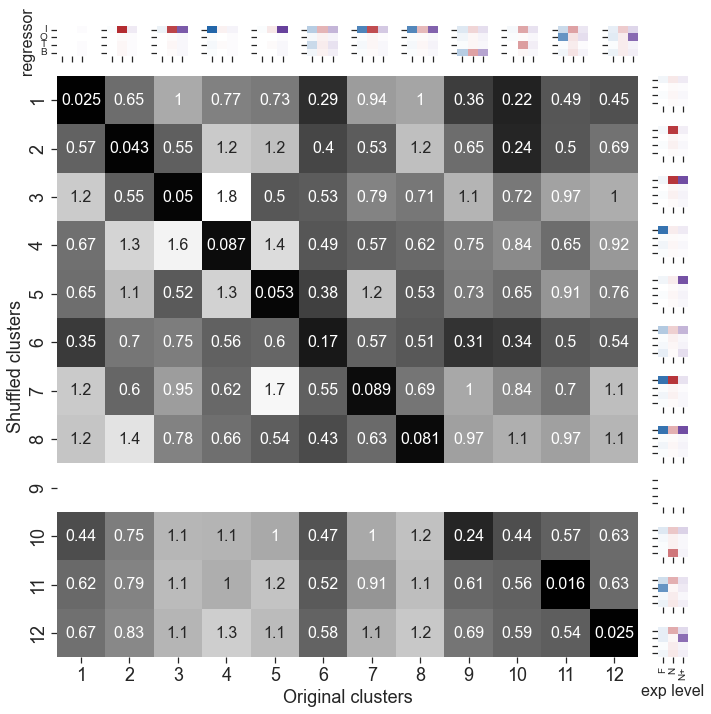

In [629]:

folder = 'figure_4/suppl_20'
fig = plotting.plot_cluster_heatmaps_with_SSE_matrix(original_cluster_means, shuffled_cluster_means, SSE_matrix_sorted,
                                               session_colors=True, experience_index=None, save_dir=None, folder=folder)

In [630]:
# somewhere task and beahvioral are switched and i cant find where
df = shuffled_cluster_means.rename(columns={'task': 'temp', 'behavioral': 'task', 'temp': 'behavioral'})
shuffled_cluster_means_patch_fix = df.rename(columns={'temp': 'behavioral'})

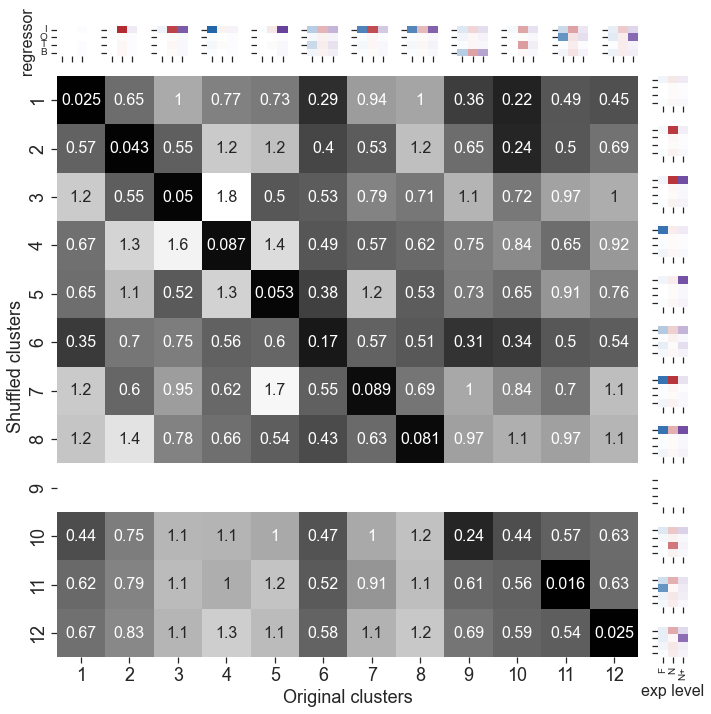

In [631]:
# in v28 suppl figures, the dataframe was not filtered for shuffle type, so this figure is slightly different
folder = 'figure_4/suppl_20'
fig = plotting.plot_cluster_heatmaps_with_SSE_matrix(original_cluster_means, shuffled_cluster_means_patch_fix, SSE_matrix_sorted,
                                               session_colors=True, experience_index=None, save_dir=fig_path, folder=folder)

In [ ]:
shuffled_clusters_dict = processing.get_matched_clusters_means_dict(SSE_mapping, nb_mean_dropout_scores_shuffled_unstacked, 
                                                                    metric='mean', shuffle_type=None, cre_line=None) 
        
shuffled_cluster_means = processing.get_shuffled_cluster_means(shuffled_clusters_dict, n_clusters)

In [750]:
# again behavioral and task are switched
shuffled_clusters_dict_fixed = {}
for cluster_id in cluster_ids:
    shuffled_clusters_dict_fixed[cluster_id] = shuffled_clusters_dict[cluster_id].rename(index={'behavioral': 'temp', 'task': 'behavioral'}).rename(index={'temp': 'task'})


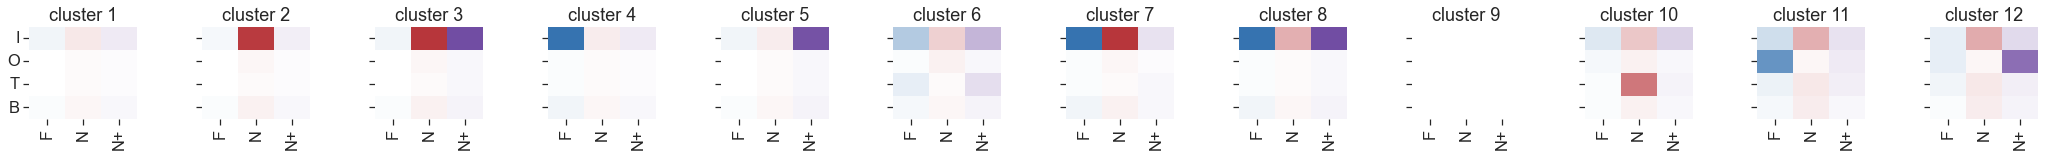

In [764]:
folder = 'figure_4/suppl_20'
plotting.plot_matched_clusters_heatmap_remapped(shuffled_clusters_dict_fixed , abbreviate_features=True, abbreviate_experience=True, small_fontsize=False,
                                  session_colors=True, save_dir=fig_path, folder=folder , figsize=(3*12, 1.7))

In [ ]:
### splitting by cre line needs work

In [775]:
# get mean dropout scores for matched clusters by cre line to plot mean matched dropout scores
SSE_mapping_dict = {}
shuffled_clusters_dict_cre = {}
shuffled_cluster_means_cre = {}
for cre_line in cre_lines:
    print(cre_line)
    SSE_mapping_dict[cre_line]=SSE_mapping
    shuffled_clusters_dict_cre[cre_line] = processing.get_matched_clusters_means_dict(SSE_mapping, cre_mean_dropout_scores_shuffled_unstack[cre_line],
                                                                    metric='mean', shuffle_type=None, cre_line=None) 
        
# replace nans with 0 in SST cluster 12
shuffled_clusters_dict_cre[cre_lines[1]][12] = shuffled_clusters_dict_cre[cre_lines[1]][12].replace(np.nan, 0)

Slc17a7-IRES2-Cre
Sst-IRES-Cre
Vip-IRES-Cre


In [776]:
# this can be removed once i figure our where the labels are switched
shuffled_clusters_dict_cre_fixed = shuffled_clusters_dict_cre.copy()
for cre_line in cre_lines:
    for cluster_id in cluster_ids:
        shuffled_clusters_dict_cre_fixed[cre_line][cluster_id] = shuffled_clusters_dict_cre[cre_line][cluster_id].rename(index={'behavioral': 'temp', 'task': 'behavioral'}).rename(index={'temp': 'task'})


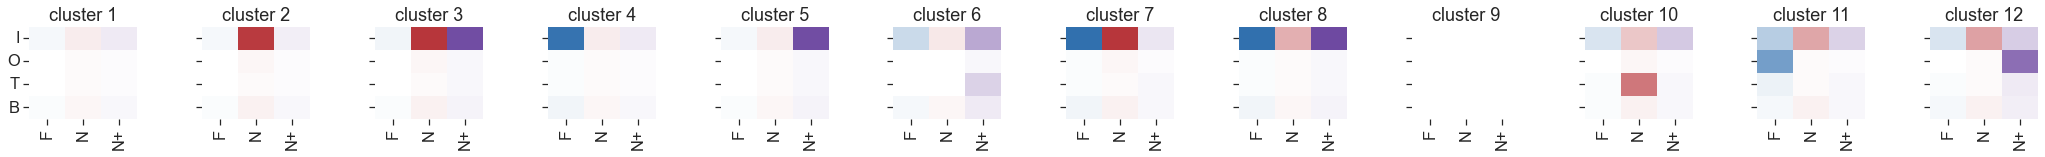

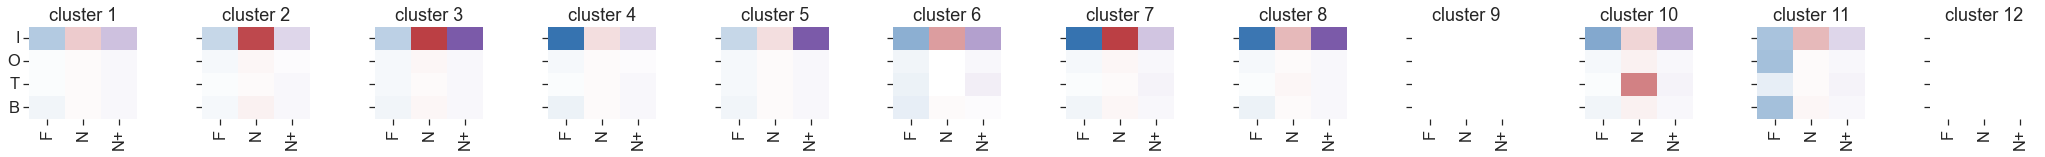

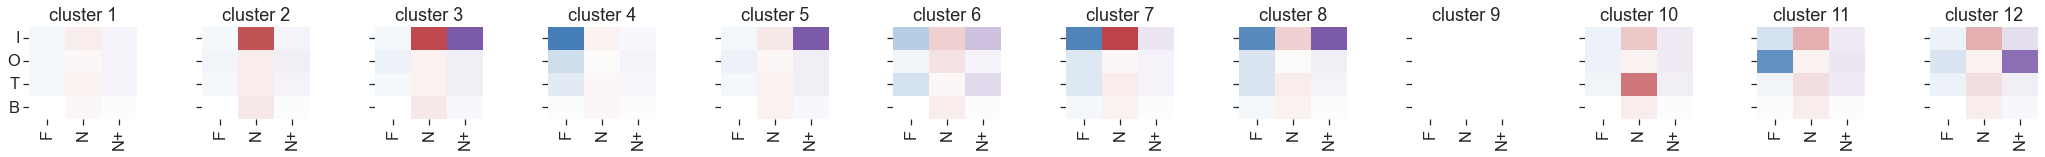

In [777]:
for cre_line in cre_lines:
    plotting.plot_matched_clusters_heatmap_remapped(shuffled_clusters_dict_cre_fixed[cre_line], abbreviate_features=True, abbreviate_experience=True, small_fontsize=False,
                                  session_colors=True, save_dir=None, folder=folder , figsize=(3*12, 1.7))

## panels e and f probability of clusters in shuffled data

This requires more thinking. Since the clusters were matched across all cells, SST and VIP cells shuffled clusters can match Exc original clusters, which makes computing sizes and probabilities across cre lines a bit consufing. 

In [352]:
## Load shuffled cluster labels
shuffled_labels_cre={}
for cre_line in cre_lines:
    nb_labels_shuffled = {}                       
    for n_boot in n_boots:
        nb_filename ='all_cells_{}_nb{}_cluster_labels.h5'.format(shuffle_type, n_boot) 
        full_filename = os.path.join(shuffle_dir, nb_filename)
        cluster_meta = pd.read_hdf(full_filename, key = 'clustered_df')
        nb_labels_shuffled[n_boot] = cluster_meta[cluster_meta.cre_line==cre_line]
    shuffled_labels_cre[cre_line] = nb_labels_shuffled


In [425]:
normalize = False
shuffled_cluster_sizes_cre = {}
for cre_line in cre_lines:
     shuffled_cluster_sizes_cre[cre_line] = processing.get_cluster_size_variance(SSE_mapping, shuffled_labels_cre[cre_line], normalize=normalize)
                
original_cluster_sizes_cre = {}
for cre_line in cre_lines:
    cluster_meta_cre = original_cluster_meta[original_cluster_meta.cre_line == cre_line]
    original_cluster_sizes_cre[cre_line] = cluster_meta_cre.value_counts('cluster_id', normalize=normalize).reindex(range(1,n_clusters+1))
    

In [426]:
normalize = True
norm_shuffled_cluster_sizes_cre = {}
for cre_line in cre_lines:
     norm_shuffled_cluster_sizes_cre[cre_line] = processing.get_cluster_size_variance(SSE_mapping, shuffled_labels_cre[cre_line], normalize=normalize)
                
norm_original_cluster_sizes_cre = {}
for cre_line in cre_lines:
    cluster_meta_cre = original_cluster_meta[original_cluster_meta.cre_line == cre_line]
    norm_original_cluster_sizes_cre[cre_line] = cluster_meta_cre.value_counts('cluster_id', normalize=normalize).reindex(range(1,n_clusters+1))
    

In [428]:
filename = os.path.join(save_dir, 'difference_in_cluster_size_shuffle_control.h5')
if os.path.exists(filename):
    cluster_size_diff = pd.read_hdf(filename, key='df')
else:
    cluster_size_diff = processing.get_cluster_size_differece_df(original_cluster_sizes_cre, 
                                                             shuffled_cluster_sizes_cre, cre_line=cre_lines)
    cluster_size_diff.to_hdf(filename, key='df')

In [429]:
filename = os.path.join(save_dir, 'difference_in_cluster_size_shuffle_control_normalized_within_group.h5')
if os.path.exists(filename):
    norm_cluster_size_diff = pd.read_hdf(filename, key='df')
else:
    norm_cluster_size_diff = processing.get_cluster_size_differece_df(norm_original_cluster_sizes_cre, 
                                                             norm_shuffled_cluster_sizes_cre, cre_line=cre_lines)
    norm_cluster_size_diff.to_hdf(filename, key='df')

In [509]:
# difference in size plotted here (x-y)/(x+y) when not normalized, may come from two different population 
# total of all used clusters. One small issue is that in original clusters we have dropped 20 cells due to being 
# too small of a cluster. In clustering of shuffled datasets we do not do that. Even if we clean shuffled labels
# the number of clusters excluded will likely also depend on each shuffle. So, N originals != N shuffled. Since populations are different, 
# there is a need to normalize. But that doesnt solve another discrepancy. The cells in clusters unmatched are disgarded.
# So the population of cells that ends up being matched is really different from original population. So when comparing the
# difference in cluster sizes, total of original clusters =3901, total of matched shuffled clsuters < 3901. 
# This will bias original clusters to be bigger than shuffled? 


# Anyway, to udress it we can normalize cluster sizes to total n in matched clusters. But I started to run into this error
# decided to abandon. Not sure if it makes sense.

# this may be an issue addressed by marina? in adjust_expected_N: 
#get_cluster_size_variance(SSE_mapping, cluster_meta_shuffled, normalize=False, use_nan=False, adjust_to_expected_N=False)

In [510]:
# shuffled_labels_cre[cre_line][0].groupby('cluster_id').count()[['cell_specimen_id']].loc[[1,4,5,6]]
# do not understand why this error comes up.
# sse = SSE_mapping[0]
# keys_without_minus_one = [int(key) for key, value in sse.items() if value != -1]
# shuffled_labels_cre[cre_line][0].groupby('cluster_id').count()[['cell_specimen_id']].loc[keys_without_minus_one]


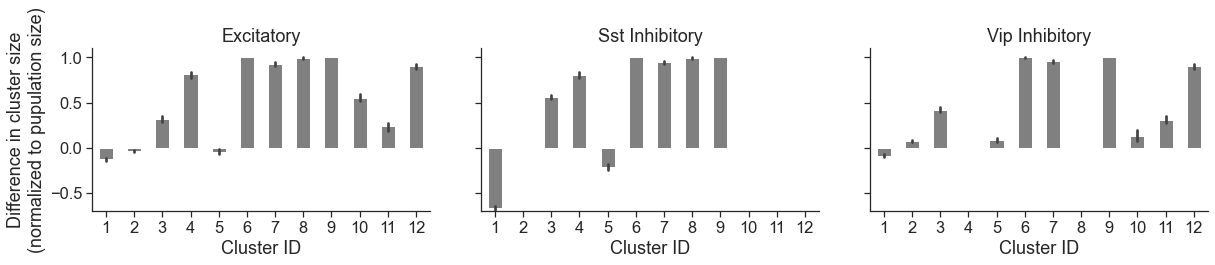

In [514]:
# since cluster n is identical to its cluster proportion, normalized and non normalized cluster size diff will be the same
# in v28 suppl figures, the dataframe was not filtered for shuffle type, so this figure is slightly different
folder = 'figure_4/suppl_20'
plotting.plot_cluster_size_difference_for_shuffle(norm_cluster_size_diff, save_dir=fig_path, folder=folder)

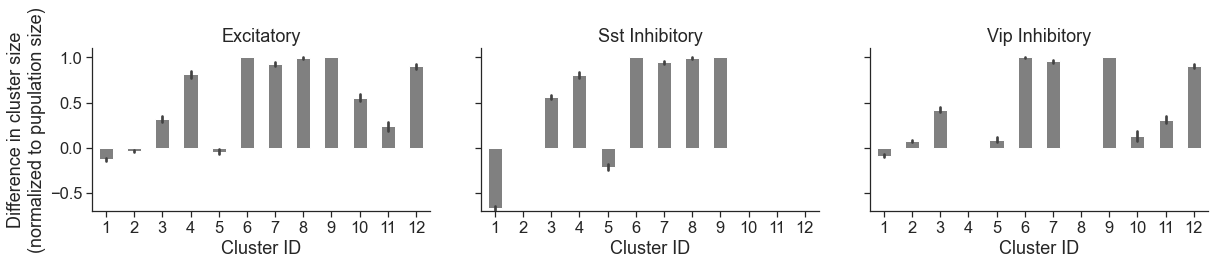

In [515]:
# not normalized
plotting.plot_cluster_size_difference_for_shuffle(cluster_size_diff, save_dir=None, folder=folder)

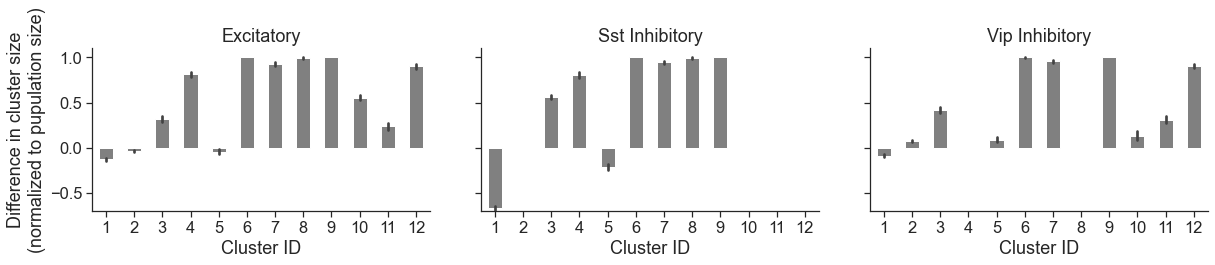

In [538]:
shuffled_cluster_sizes_cre_test = {}
# after editing keyerror behavior on line 3452 of processing to include 0 or nan not break.
for cre_line in cre_lines:
    shuffled_cluster_sizes_cre_test[cre_line] = processing.get_cluster_size_variance(SSE_mapping, shuffled_labels_cre[cre_line], normalize=normalize)

cluster_size_diff_test = processing.get_cluster_size_differece_df(original_cluster_sizes_cre, 
                                                             shuffled_cluster_sizes_cre_test, cre_line=cre_lines)
plotting.plot_cluster_size_difference_for_shuffle(cluster_size_diff_test, save_dir=None, folder=folder)

#### Probability

In [516]:
# by cre line
# this is attempt to replicate how probability was computed before.
# But it seems incorrect to use a different SSE map split by cre becuase the clusters should be matched agnostically 
# from cre line. This does not replicate previous results. Plus creates difference in clusters that should be 0 (Like SST 2)
SSE_matrix_filename = os.path.join(save_dir, 'SSE_matrix_shuffled_nboot_by_cre.pkl')
if os.path.exists(SSE_matrix_filename):
    with open(SSE_matrix_filename, 'rb') as f:
        SSE_matrix_cre = pickle.load(f)
else:
    SSE_matrix_cre = {}
    for cre_line in cre_lines: 
        SSE_matrix_nb = {}
        for n in n_boots:
            SSE_matrix_nb[n] = processing.compute_SSE(mean_dropout_df_original = original_mean_dropout_scores, 
                               mean_dropout_df_compare=cre_mean_dropout_scores_shuffled[cre_line][n])
    
        # SSE values based on dropout scores of mean cre coding scores per cluster. 
        SSE_matrix_cre[cre_line]= SSE_matrix_nb


SSE_mapping_cre = {}
for cre_line in cre_lines:
    SSE_mapping_cre[cre_line] = processing.get_cluster_mapping(SSE_matrix_cre[cre_line], threshold = 0.1)
    
cluster_probabilities_cre = {}
for cre_line in cre_lines:
    print(cre_line)
    cluster_probabilities_cre[cre_line] = processing.compute_probabilities(SSE_mapping_cre[cre_line], shuffled_labels_cre[cre_line])


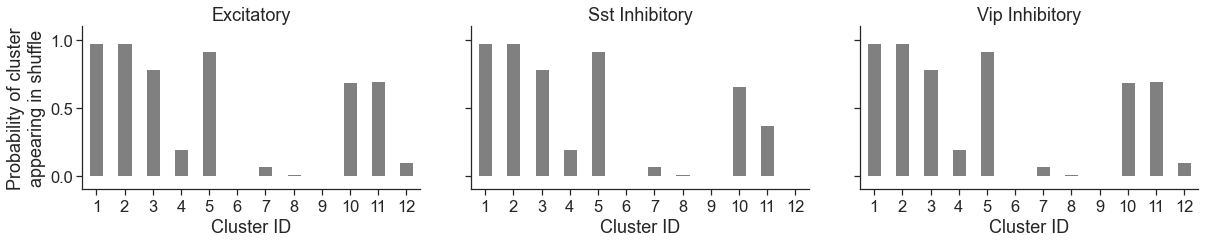

In [517]:
plotting.plot_cluster_probability_for_shuffle(probability_dict_cre, save_dir=None, folder=folder)

In [518]:
# use one SSE map
cluster_probabilities_cre = {}
for cre_line in cre_lines:
    print(cre_line)
    cluster_probabilities_cre[cre_line] = processing.compute_probabilities(SSE_mapping, shuffled_labels_cre[cre_line])

probability_dict_cre_2= processing.get_cluster_probability_df(cluster_probabilities_cre,
                                                                              cre_lines= cre_lines)

Slc17a7-IRES2-Cre
Sst-IRES-Cre
Vip-IRES-Cre


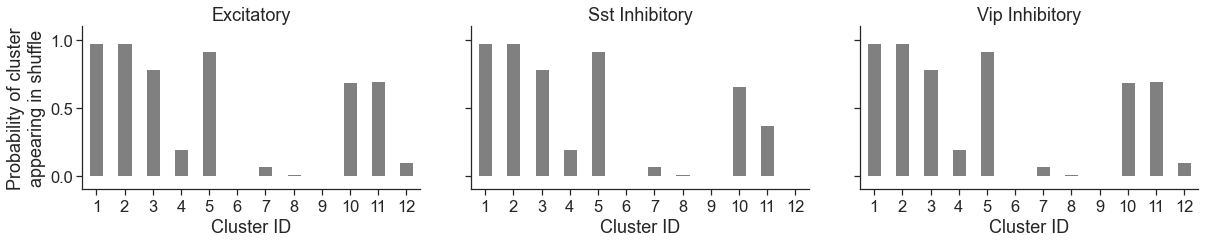

In [519]:
plotting.plot_cluster_probability_for_shuffle(probability_dict_cre_2, save_dir=None, folder=folder)

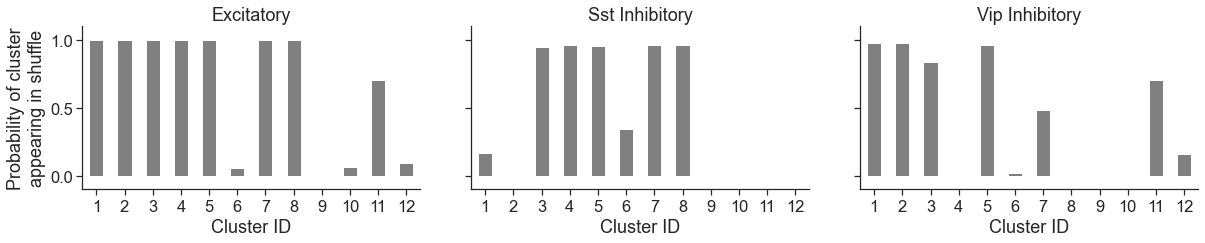

In [521]:
# original Cell id shuffle only
tmp_save_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4\all_cre_clustering_082823_n_14\240101_SSE_general'
pkl_filename = 'Probability_for_Marina.pkl'
probability_dict = pd.read_pickle(os.path.join(tmp_save_dir, pkl_filename))
probability = pd.DataFrame(probability_dict[threshold])
probability_clean = probability[probability.shuffle_type=='experience']
plotting.plot_cluster_probability_for_shuffle(probability_clean, save_dir=fig_path, folder=folder)


In [378]:
### Need to come back to this issue

        

# Familiar control

## Supplemental figure 24

In [787]:
cells_table = processing.get_cells_matched_in_3_familiar_active_sessions()
# add unique identifier for ophys_expt_id + csid pairs so it can be merged with results_pivoted
cells_table['identifier'] = [str(cells_table.iloc[row].ophys_experiment_id)+'_'+str(cells_table.iloc[row].cell_specimen_id) for row in range(len(cells_table))]
cells_table = cells_table.set_index('identifier')

1244 experiments
452 familiar active experiments
['Familiar']
['OPHYS_1_images_A' 'OPHYS_3_images_A' 'OPHYS_1_images_B'
 'OPHYS_3_images_B']
451 experiments in filtered cells table
17990 familiar active cell_specimen_ids
17990 familiar active cell_specimen_ids
5 familiar active session numbers
checking session counts: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
1450 cell_specimen_ids in at least 3 sessions
['Familiar']
['OPHYS_3_images_A' 'OPHYS_1_images_A' 'OPHYS_1_images_B'
 'OPHYS_3_images_B']
1450 familiar active cell_specimen_ids in the first 3 sessions
3 familiar active session numbers
1450 familiar active cell_specimen_ids
1450 familiar active cell_specimen_ids
3 familiar active session numbers
experience_levels:  ['Familiar 1' 'Familiar 2' 'Familiar 3']


In [789]:
version = '24_events_all_L2_optimize_by_session'

run_params, results, results_pivoted, weights_df = gfd.load_analysis_dfs(version)

loading run_params
loading results df
loading results_pivoted df
loading weights_df


In [790]:
# add new experience levels for familiar active sessions to results pivoted
# and limit results pivoted to cells matched in 3 familiar sessions
results_pivoted = results_pivoted.drop(columns='experience_level')
results_pivoted = results_pivoted.merge(cells_table[[ 'experience_level']], on='identifier')
results_pivoted.experience_level.unique()

array(['Familiar 1', 'Familiar 2', 'Familiar 3'], dtype=object)

In [791]:
print(len(results_pivoted.ophys_experiment_id.unique()))
print(len(results_pivoted.cell_specimen_id.unique()))
print(results_pivoted.project_code.unique())
print(results_pivoted.session_type.unique())

171
1450
['VisualBehaviorTask1B' 'VisualBehavior' 'VisualBehaviorMultiscope']
['OPHYS_1_images_B' 'OPHYS_3_images_B' 'OPHYS_1_images_A'
 'OPHYS_3_images_A']


In [792]:
# limit to features used for clustering
features = processing.get_features_for_clustering()
features = ['all-images', 'omissions', 'task', 'behavioral']
features = [*features, 'ophys_experiment_id']
results_pivoted = processing.limit_results_pivoted_to_features_for_clustering(results_pivoted, features)

# flip sign so coding scores are positive
results_pivoted = processing.flip_sign_of_dropouts(results_pivoted, processing.get_features_for_clustering(), use_signed_weights=False)

# now drop ophys_experiment_id
results_pivoted = results_pivoted.drop(columns=['ophys_experiment_id'])

In [794]:
save_dir_familiar = os.path.join(save_dir, 'familiar_only_clustering')

In [819]:
feature_matrix = processing.get_feature_matrix_for_clustering(results_pivoted, version, save_dir=save_dir_familiar)

No duplicated cells found
1450


### gap statistic

In [796]:

metric = 'euclidean' # default distance metric
shuffle_type ='all' # default shuffle type is all shuffle (cell id and regressors
k_max = 25 #max number of clusters to test

gap_filename = os.path.join(save_dir_familiar, 'gap_scores_{}_{}_nb20_unshuffled_to_{}.pkl'.format(metric, version, shuffle_type))
if os.path.exists(gap_filename):
    with open(gap_filename, 'rb') as f:
        gap_df = pickle.load(f)
        print('loaded file')
else:
    
    sc = SpectralClustering()
    gap_df = processing.compute_gap(clustering=sc, data=feature_matrix, k_max = k_max, 
                                    reference_shuffle=shuffle_type, metric=metric, separate_cre_lines=True)
    processing.save_clustering_results(gap_df, gap_filename)

loaded file


In [798]:
folder = 'figure_4/suppl_24'

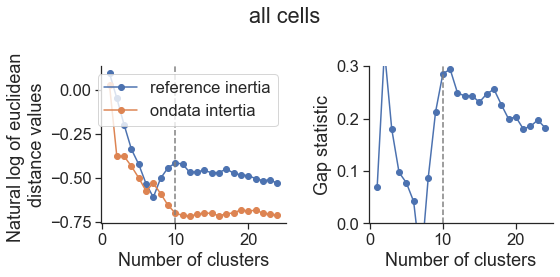

In [799]:

plotting.plot_gap_statistic(gap_df, cre_lines=['all'], n_clusters_cre=10, 
                            tag='with_cre_shuffle', save_dir=fig_path, folder=folder)

### panel b and c - coclustering matrix

In [800]:
# number of optimal clusters
n_clusters = 10

coclust_filename = os.path.join(save_dir_familiar, 'coclustering_matrix_n_' + str(n_clusters) + '_clusters.h5')

if os.path.exists(coclust_filename):
    coclustering_df = pd.read_hdf(coclust_filename, key='df')
    print('found and loaded cached coclustering matrix file...')
else:
    print('did not find cached coclustering matrix file, will make one...')
    sc = SpectralClustering()
    X = feature_matrix.values
    m = processing.get_coClust_matrix(X=X, n_clusters=n_clusters, model=sc, nboot=np.arange(150))
    # make co-clustering matrix a dataframe with cell_specimen_ids as indices and columns
    coclustering_df = pd.DataFrame(data=m, index=feature_matrix.index, columns=feature_matrix.index)

    # save co-clustering matrix
    coclust_save_file = os.path.join(glm_path, 'coclustering_matrix_n_' + str(n_clusters) + '_clusters.h5')
    coclustering_df.to_hdf(coclust_filename, key='df', format='table')
    print('created and saved coclustering_matrix file.')

found and loaded cached coclustering matrix file...


In [820]:
n_clusters = 10 # based on eigen gap

cluster_meta_save_path = os.path.join(save_dir_familiar, 'cluster_meta_n_'+str(n_clusters)+'_clusters.h5')

# if clustering output exists, load it
if os.path.exists(cluster_meta_save_path):
    print('loading results')
    cluster_meta = pd.read_hdf(cluster_meta_save_path, key='df')
    # merge in cell metadata
    cell_metadata = processing.get_cell_metadata_for_feature_matrix(feature_matrix, cells_table)
    cell_metadata = cell_metadata.drop(columns=['ophys_experiment_id', 'cre_line'])
    cluster_meta = cluster_meta.merge(cell_metadata.reset_index(), on='cell_specimen_id')
    cluster_meta = cluster_meta.set_index('cell_specimen_id')
# otherwise run it and save it
else: 

    # run agglomerative clustering on co-clustering matrix to identify cluster labels
    from sklearn.cluster import AgglomerativeClustering
    X = coclustering_df.values
    cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean',
                                    linkage='average')
    labels = cluster.fit_predict(X)
    cell_specimen_ids = coclustering_df.index.values
    # make dictionary with labels for each cell specimen ID in this cre line
    labels_dict = {'labels': labels, 'cell_specimen_id': cell_specimen_ids}
    # turn it into a dataframe
    labels_df = pd.DataFrame(data=labels_dict, columns=['labels', 'cell_specimen_id'])
    # get new cluster_ids based on size of clusters and add to labels_df
    cluster_size_order = labels_df['labels'].value_counts().index.values
    # translate between original labels and new IDS based on cluster size
    labels_df['cluster_id'] = [np.where(cluster_size_order == label)[0][0] for label in labels_df.labels.values]
    # concatenate with df for all cre lines
    cluster_labels = labels_df

    # limit cells_table to cells in feature_matrix and drop duplicates 
    cell_metadata = processing.get_cell_metadata_for_feature_matrix(feature_matrix, cells_table)
    # cluster_meta will only have one row per cell_specimen_id 

    cluster_meta = cluster_labels[['cell_specimen_id', 'cluster_id', 'labels']].merge(cell_metadata, on='cell_specimen_id')
    cluster_meta = cluster_meta.set_index('cell_specimen_id')
    cluster_meta['cluster_id'] = cluster_meta['cluster_id'].copy()+1
    # annotate & clean cluster metadata
    cluster_meta = processing.clean_cluster_meta(cluster_meta)  # drop cluster IDs with fewer than 5 cells in them
    cluster_meta['original_cluster_id'] = cluster_meta.cluster_id

    # add within cluster correlation
    cluster_meta = processing.add_within_cluster_corr_to_cluster_meta(feature_matrix, cluster_meta, use_spearmanr=True)

    # save clustering results
    print('saving results')
    cluster_meta_save_path = os.path.join(save_dir, 'cluster_meta_n_'+str(n_clusters)+'_clusters.h5')
    cluster_data = cluster_meta.reset_index()[['cell_specimen_id', 'ophys_experiment_id', 'cre_line', 'cluster_id', 'labels', 'within_cluster_correlation']]
    cluster_data.to_hdf(cluster_meta_save_path, key='df', format='table')


loading results
1450 cells in cell_metadata for feature_matrix


In [827]:
coclust_save_path = os.path.join(save_dir_familiar, 'coclustering_matrix_n_'+str(n_clusters)+'_clusters.h5')
if os.path.exists(coclust_save_path):
    coclustering_df = pd.read_hdf(coclust_save_path, key='df')
else:

    from sklearn.cluster import SpectralClustering
    sc = SpectralClustering()
    X = feature_matrix.values
    m = processing.get_coClust_matrix(X=X, n_clusters=n_clusters, model=sc, nboot=np.arange(100))
    # make co-clustering matrix a dataframe with cell_specimen_ids as indices and columns
    coclustering_df = pd.DataFrame(data=m, index=feature_matrix.index, columns=feature_matrix.index)

    # save co-clustering matrix
    coclustering_df.to_hdf(coclust_save_path, key='df', format='table')


<AxesSubplot:ylabel='cells'>

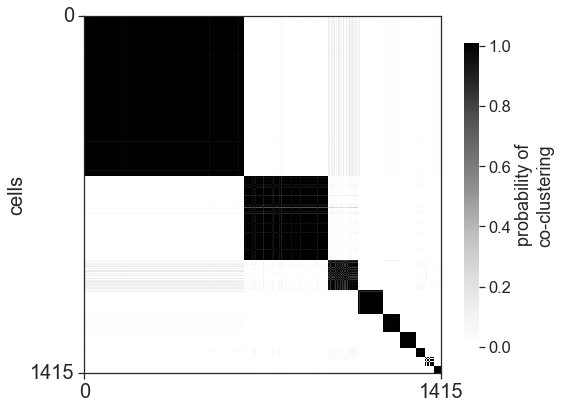

In [828]:
coclustering_dict = {}
coclustering_dict['all'] = coclustering_df
cluster_meta_tmp = cluster_meta.copy()
cluster_meta_tmp['cre_line'] = 'all'
plotting.plot_coclustering_matrix_sorted_by_cluster_size(coclustering_dict, cluster_meta_tmp, cre_line='all',
                                                                 save_dir=fig_path, folder=folder,
                                                                 suffix='_' + str(n_clusters) + '_clusters', ax=None)

### panel d and f - cluster heatmaps

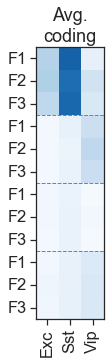

In [804]:
plotting.plot_cre_line_means_remapped(feature_matrix, cluster_meta, session_colors=False, experience_index=0)

<AxesSubplot:title={'center':'Cluster averages'}, xlabel='Cluster ID'>

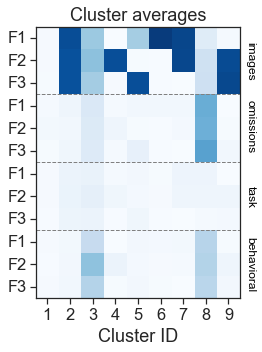

In [809]:
plotting.plot_cluster_means_remapped(feature_matrix, cluster_meta, session_colors=False,
                                     experience_index=0, save_dir=fig_path, folder=folder, ax=None)

<AxesSubplot:xlabel='Cluster ID'>

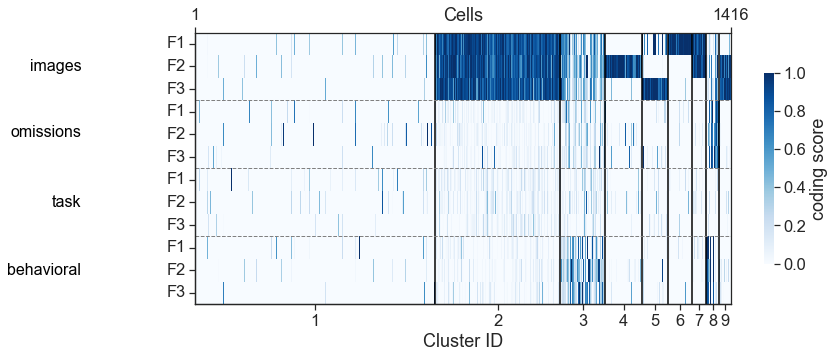

In [824]:
plotting.plot_coding_score_heatmap_remapped(cluster_meta, feature_matrix, sort_by='cluster_id', session_colors=False,
                                    experience_index=0, save_dir=fig_path, folder=folder, ax=None)

9 9
2 9
5 9


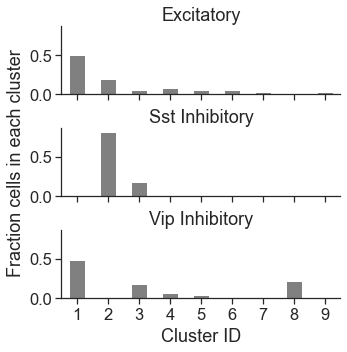

In [825]:
plotting.plot_fraction_cells_per_cluster_per_cre(cluster_meta, col_to_group='cre_line', 
                                                    save_dir=fig_path, folder=folder)

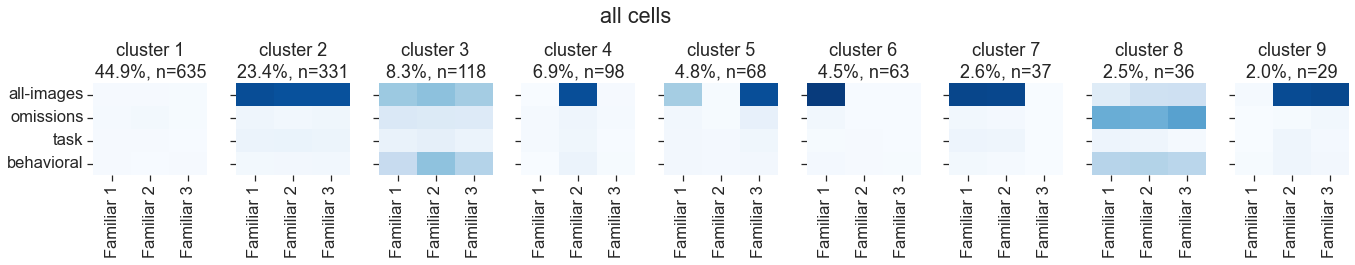

In [823]:
cre_line='all'
clusters = cluster_meta.value_counts('cluster_id').index.values
plotting.plot_mean_cluster_heatmaps_remapped(feature_matrix, cluster_meta, 
                                                 cre_line, clusters, session_colors=False, 
                                                 experience_index=0, save_dir=fig_path, folder=folder)

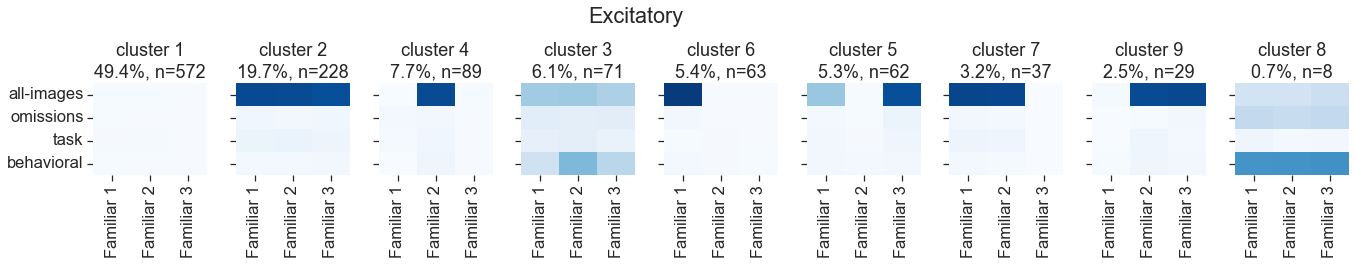

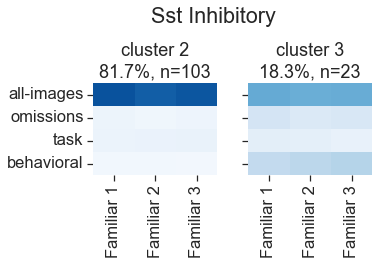

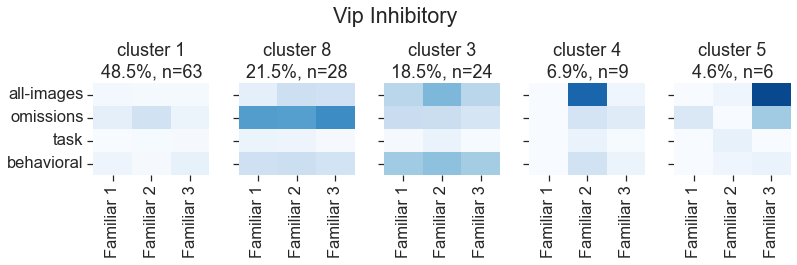

In [810]:
for cre_line in cre_lines:
    cluster_meta_cre = cluster_meta[cluster_meta.cre_line==cre_line]
    clusters = cluster_meta_cre.value_counts('cluster_id').index.values
    plotting.plot_mean_cluster_heatmaps_remapped(feature_matrix, cluster_meta_cre, 
                                                 cre_line, clusters, session_colors=False, 
                                                 experience_index=0, save_dir=fig_path, folder=folder)

### Mean response traces for clusters per cre line

In [811]:
data_type = 'events'

interpolate = True
output_sampling_rate = 30

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels']
inclusion_criteria = ''

In [812]:
# params for stim response df creation
event_type = 'all'

# params for mean response df creation
conditions = ['cell_specimen_id', 'is_change']


change_suffix = '_'+utils.get_conditions_string(data_type, conditions)+'_'+inclusion_criteria

multi_session_df = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria, 
                                                        interpolate=interpolate, output_sampling_rate=output_sampling_rate, 
                                                         epoch_duration_mins=None)

change_mdf = multi_session_df[multi_session_df.is_change==True]

loading files from \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz
mean_response_df_events_all_is_change_.pkl
loading multi_session_df from saved file at \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz\mean_response_df_events_all_is_change_.pkl
there are 1249 experiments in the full multi_session_df
removing 1 problematic experiments
there are 1243 experiments after filtering for inclusion criteria -  


In [813]:
import visual_behavior.visualization.ophys.platform_paper_figures as ppf

In [814]:
tmp = multi_session_df.copy()
tmp = tmp[tmp.is_change==False]
# add new experience level to to mdf by merging in cells_table
tmp = tmp.drop(columns='experience_level').merge(cells_table[['cell_specimen_id', 'ophys_experiment_id', 'experience_level']], on=['ophys_experiment_id', 'cell_specimen_id'])
# add cluster_id by merging in cluster meta
tmp = tmp.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')


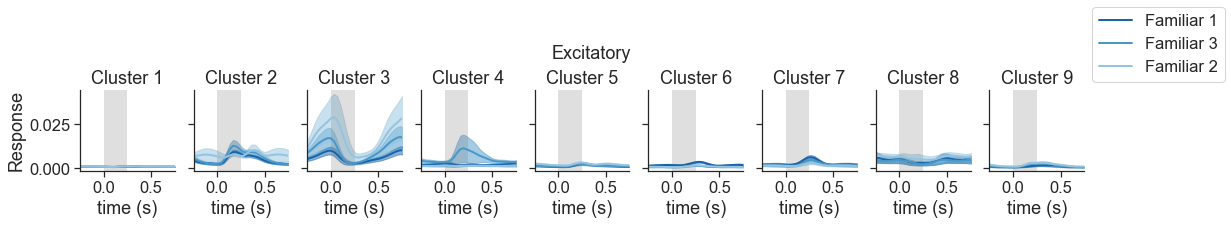

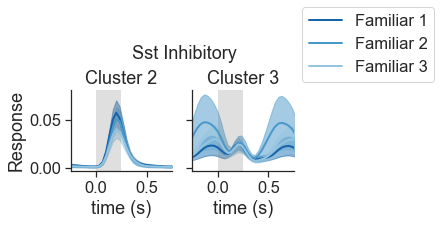

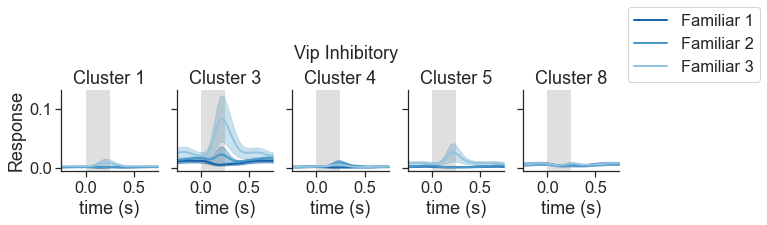

In [816]:
for cre_line in np.sort(tmp.cre_line.unique()):
    df = tmp[tmp.cre_line==cre_line].copy()

    axes_column = 'cluster_id'
    hue_column = 'experience_level'
    # xlim_seconds=[-1., 1.5]
    xlim_seconds=[-0.25, 0.75]
    cell_type = processing.get_cell_type_for_cre_line(cre_line)
    ax= plotting.plot_population_averages_for_clusters(df, event_type, axes_column, hue_column, session_colors=False, experience_index=0,legend=True,
                                            xlim_seconds=xlim_seconds, interval_sec=0.5, 
                                            sharey=True, sharex=False, 
                                            ylabel='response', xlabel='time (s)', suptitle=cell_type,
                                            save_dir=fig_path, folder=folder, suffix='_sharey', ax=None);


In [ ]:
### panel e - distribution 

In [830]:
feature

all-images                     omissions                      \
experience_level   Familiar     Novel   Novel +  Familiar     Novel   Novel +   
cell_specimen_id                                                                
1086489847         0.640668  0.000000  0.000000  0.553982  0.000000  0.021992   
1086489860         0.000000  0.114102  0.000000  0.572067  0.118406  0.000000   
1086489891         0.488487  0.013765  0.020571  0.221096  0.391435  0.014216   
1086490397         0.286015  0.524304  0.000000  0.448332  0.239929  0.000000   
1086490441         0.000000  0.000000  0.696512  0.000000  0.000000  0.000000   
...                     ...       ...       ...       ...       ...       ...   
1086673279         0.000000  0.286256  0.000000  0.537283  0.000000  0.000000   
1086673299         0.000000  0.000000  0.001178  0.000000  0.000000  0.000000   
1086673376         0.110550  0.117579  0.000000  0.291987  0.000000  0.000000   
1086673402         0.000000  0.130752  0.000000  0.000000  0.000000  0.000000   
1086673591         0.000000  0.000000  0.287905  0.000000  0.000000  0.619703   

                      task                     behavioral                      
experience_level  Familiar     Novel   Novel +   Familiar     Novel   Novel +  
cell_specimen_id                                                               
1086489847        0.029937  0.000000  0.000000   0.157060  0.000000  0.475810  
1086489860        0.000000  0.022355  0.043245   0.000000  0.062504  0.000000  
1086489891        0.002615  0.020108  0.019703   0.396766  0.000000  0.909574  
1086490397        0.112571  0.210466  0.000000   0.052926  0.049884  0.000000  
1086490441        0.000000  0.000000  0.000000   0.000000  0.000000  0.283583  
...                    ...       ...       ...        ...       ...       ...  
1086673279        0.000000  0.000000  0.000000   0.000000  0.563228  0.000000  
1086673299        0.000000  0.000000  0.029499   0.000000  0.000000  0.706578  
1086673376        0.000000  0.125134  0.000000   0.167368  0.151825  0.000000  
1086673402        0.000000  0.185793  0.000000   0.000000  0.506952  0.000000  
1086673591        0.000000  0.000000  0.005275   0.000000  0.000000  0.365764  

[409 rows x 12 columns]